### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between input current configuration between output magnetic field 

In [19]:
%reload_ext autoreload
%autoreload 2
import numpy
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Using cpu


In [20]:
from ReadData import ReadFolder 
import glob
import os
# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
data = ReadFolder(foldername,filepattern)
fileList = glob.glob(foldername+filepattern)
position = data[:,:,:3].reshape(-1,3)
Bfield = data[:,:,3:].reshape(-1,3)
print(fileList)
print(data.shape)
print('Bfield shape', Bfield.shape)


['./Data/MagneticField0.txt']
torch.Size([1, 9260, 6])
Bfield shape torch.Size([9260, 3])


In [30]:
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
from Training_loop import train_part


batch_size = 128
# construct dataset
dataset = eMNS_Dataset(
    train_x=position,
    train_y=Bfield
)

# split the dataset to train, validation, test
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [0.7,0.2,0.1])

#Using Dataloader for batch train
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)


###############################################
# Config the neural network
###############################################
num_input = 3
num_output = 3
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)
epochs = 50
learning_rate_decay = .1
learning_rates = [1e-3]
schedule = []
weight_decays = [0]


################################################
# Train the neural network
################################################

for learning_rate in learning_rates:
    for weight_decay in weight_decays:
        fc_network.apply(weight_init)
        optimizer = torch.optim.Adam([{'params':fc_network.parameters()}], lr=learning_rate, weight_decay= weight_decay)
        RMSE_history, RMSE_val_history, loss_history, iter_history = train_part(model=fc_network, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, epochs=epochs, learning_rate_decay=learning_rate_decay, schedule=schedule, weight_decay=weight_decay, verbose=False, device=device)


Epoch 0, Iteration 51, loss = 0.0000
Got RMSE 0.002840587170794606
Got RMSE 0.002834184793755412

Epoch 1, Iteration 102, loss = 0.0000
Got RMSE 0.0018714044708758593
Got RMSE 0.0018479787977412343

Epoch 2, Iteration 153, loss = 0.0000
Got RMSE 0.0015329973539337516
Got RMSE 0.0015032028313726187

Epoch 3, Iteration 204, loss = 0.0000
Got RMSE 0.0013352030655369163
Got RMSE 0.0012885769829154015

Epoch 4, Iteration 255, loss = 0.0000
Got RMSE 0.0011679577874019742
Got RMSE 0.001134809572249651

Epoch 5, Iteration 306, loss = 0.0000
Got RMSE 0.0010678927646949887
Got RMSE 0.0010428510140627623

Epoch 6, Iteration 357, loss = 0.0000
Got RMSE 0.0009626870742067695
Got RMSE 0.0009302172693423927

Epoch 7, Iteration 408, loss = 0.0000
Got RMSE 0.0009110799874179065
Got RMSE 0.0008783970843069255

Epoch 8, Iteration 459, loss = 0.0000
Got RMSE 0.0008659068262204528
Got RMSE 0.0008266111253760755

Epoch 9, Iteration 510, loss = 0.0000
Got RMSE 0.0008327167015522718
Got RMSE 0.000793805287685

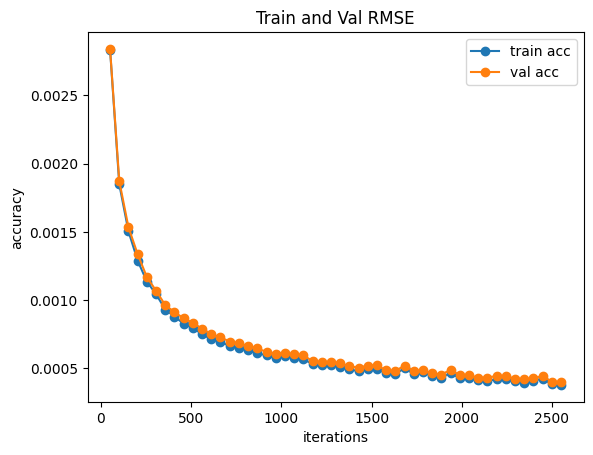

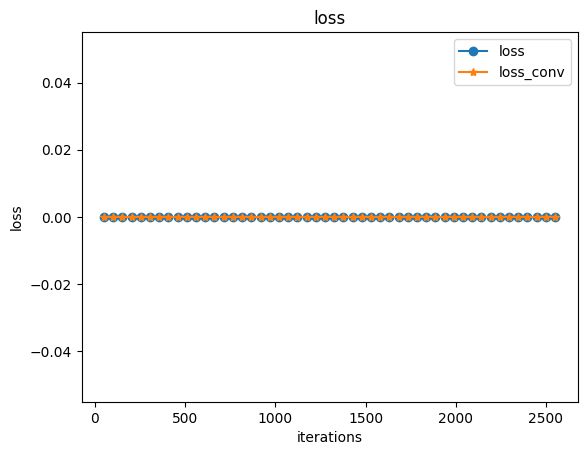

In [31]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')
plt.title('Train and Val RMSE')
plt.plot(iter_history,RMSE_history,'-o')
plt.plot(iter_history,RMSE_val_history,'-o')
plt.legend(['train acc','val acc'])
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()
plt.title('loss')
plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.plot(iter_history,loss_history_conv,'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()